In [1]:
from simpler import load

data = '''
029A
980A
179A
456A
379A
'''
# data = load('21.txt')
codes = data.strip().split('\n')

In [2]:
positions = {
	# numeric
	True: {'7': (0, 0), '8': (0, 1), '9': (0, 2), '4': (1, 0), '5': (1, 1), '6': (1, 2), '1': (2, 0), '2': (2, 1), '3': (2, 2), '0': (3, 1), 'A': (3, 2)},
	# directional
	False: {'^': (0, 1), 'A': (0, 2), '<': (1, 0), 'v': (1, 1), '>': (1, 2)}
}
def movements(code, numeric=True):
	x, y = positions[numeric]['A']
	res = ''
	for c in code:
		tx, ty = positions[numeric][c]
		if ty < y: res += '<' * (y - ty)
		if tx > x: res += 'v' * (tx - x)
		if tx < x: res += '^' * (x - tx)
		if ty > y: res += '>' * (ty - y)
		res += 'A'
		x, y = tx, ty
	return res

res = 0
for code in codes:
	print(len(movements(movements(movements(code), False), False)), '*', int(code[:-1]))
	res += int(code[:-1]) * len(movements(movements(movements(code), False), False))
res

68 * 29
60 * 980
64 * 179
60 * 456
64 * 379


123844

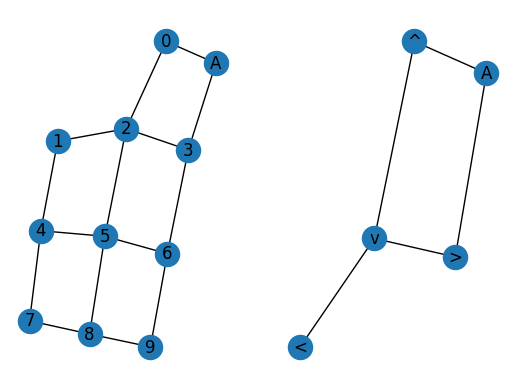

In [ ]:
from networkx import Graph, draw
import matplotlib.pyplot as plt

def build_graph(rows):
	res = Graph()
	for r, row in enumerate(rows):
		for c, val in enumerate(row):
			if val == ' ': continue
			res.add_node(val)
			if c > 0 and row[c - 1] != ' ': res.add_edge(val, row[c - 1])
			if r > 0 and rows[r - 1][c] != ' ': res.add_edge(val, rows[r - 1][c])
	return res

directional = build_graph(('789', '456', '123', ' 0A'))
numeric = build_graph((' ^A', '<v>'))

plt.subplot(121)
draw(directional, with_labels=True)
plt.subplot(122) 
draw(numeric, with_labels=True)
plt.show()

In [38]:
from networkx import all_shortest_paths, shortest_path

def pair_costs(graph, symbols, subcosts=None):
	res = {}
	for s1 in symbols:
		for s2 in symbols:
			if subcosts is None:
				res[s1, s2] = len(shortest_path(graph, s1, s2))
			else:
				res[s1, s2] = min(
					sum(subcosts[a, b] for a, b in zip(path, path[1:])) + 1
					for path in all_shortest_paths(graph, s1, s2)
				)
	return res

costs = pair_costs(numeric, '^v<>A')
costs = pair_costs(numeric, '^v<>A', costs)
costs

{('^', '^'): 1,
 ('^', 'v'): 3,
 ('^', '<'): 5,
 ('^', '>'): 5,
 ('^', 'A'): 3,
 ('v', '^'): 3,
 ('v', 'v'): 1,
 ('v', '<'): 3,
 ('v', '>'): 3,
 ('v', 'A'): 5,
 ('<', '^'): 5,
 ('<', 'v'): 3,
 ('<', '<'): 1,
 ('<', '>'): 5,
 ('<', 'A'): 7,
 ('>', '^'): 5,
 ('>', 'v'): 3,
 ('>', '<'): 5,
 ('>', '>'): 1,
 ('>', 'A'): 3,
 ('A', '^'): 3,
 ('A', 'v'): 5,
 ('A', '<'): 7,
 ('A', '>'): 3,
 ('A', 'A'): 1}

In [102]:
from networkx import DiGraph, all_shortest_paths, shortest_path_length

def grid_graph(rows):
	res = DiGraph()
	for r, row in enumerate(rows):
		for c, val in enumerate(row):
			if val == ' ': continue
			res.add_node(val)
			if c > 0 and row[c - 1] != ' ':
				res.add_edge(val, row[c - 1], move='<')
				res.add_edge(row[c - 1], val, move='>')
			if r > 0 and rows[r - 1][c] != ' ':
				res.add_edge(val, rows[r - 1][c], move='^')
				res.add_edge(rows[r - 1][c], val, move='v')
	return res

def path_to_moves(graph, path):
	return [graph[s1][s2]['move'] for s1, s2 in zip(path, path[1:])] + ['A']

numeric = grid_graph(('789', '456', '123', ' 0A'))
directional = grid_graph((' ^A', '<v>'))

def pair_costs(graph, symbols, subcosts=None):
	res = {}
	for s1 in symbols:
		for s2 in symbols:
			if subcosts is None:
				res[s1, s2] = shortest_path_length(graph, s1, s2) + 1, path_to_moves(graph, next(all_shortest_paths(graph, s1, s2)))
			else:
				min_cost = float('inf')
				for path in all_shortest_paths(graph, s1, s2):
					moves = path_to_moves(graph, path)
					cost = sum(subcosts[a, b] for a, b in zip(moves, moves[1:]))
					if cost < min_cost: min_cost = cost
				res[s1, s2] = min_cost + 1
	return res

pad_dir1_costs = pair_costs(directional, '^v<>A')
pad_dir1_costs
# pad_dir2_costs = pair_costs(directional, '^v<>A', pad_dir1_costs)
# pad_num1_costs = pair_costs(numeric, '0123456789A', pad_dir2_costs)
# pad_num1_costs

{('^', '^'): (1, ['A']),
 ('^', 'v'): (2, ['v', 'A']),
 ('^', '<'): (3, ['v', '<', 'A']),
 ('^', '>'): (3, ['>', 'v', 'A']),
 ('^', 'A'): (2, ['>', 'A']),
 ('v', '^'): (2, ['^', 'A']),
 ('v', 'v'): (1, ['A']),
 ('v', '<'): (2, ['<', 'A']),
 ('v', '>'): (2, ['>', 'A']),
 ('v', 'A'): (3, ['^', '>', 'A']),
 ('<', '^'): (3, ['>', '^', 'A']),
 ('<', 'v'): (2, ['>', 'A']),
 ('<', '<'): (1, ['A']),
 ('<', '>'): (3, ['>', '>', 'A']),
 ('<', 'A'): (4, ['>', '^', '>', 'A']),
 ('>', '^'): (3, ['<', '^', 'A']),
 ('>', 'v'): (2, ['<', 'A']),
 ('>', '<'): (3, ['<', '<', 'A']),
 ('>', '>'): (1, ['A']),
 ('>', 'A'): (2, ['^', 'A']),
 ('A', '^'): (2, ['<', 'A']),
 ('A', 'v'): (3, ['<', 'v', 'A']),
 ('A', '<'): (4, ['<', 'v', '<', 'A']),
 ('A', '>'): (2, ['v', 'A']),
 ('A', 'A'): (1, ['A'])}

In [77]:
from networkx import DiGraph, all_shortest_paths, shortest_path_length

def grid_graph(rows):
	res = DiGraph()
	for r, row in enumerate(rows):
		for c, val in enumerate(row):
			if val == ' ': continue
			res.add_node(val)
			if c > 0 and row[c - 1] != ' ':
				res.add_edge(val, row[c - 1], move='<')
				res.add_edge(row[c - 1], val, move='>')
			if r > 0 and rows[r - 1][c] != ' ':
				res.add_edge(val, rows[r - 1][c], move='^')
				res.add_edge(rows[r - 1][c], val, move='v')
	return res

def path_to_moves(G, path):
	return [G[path[i]][path[i+1]]['move'] for i in range(len(path)-1)] + ['A']

def get_costs(G, prev_costs=None):
	costs = {}
	for s1 in G:
		for s2 in G:
			if prev_costs is None:
				costs[s1,s2] = shortest_path_length(G, s1, s2) + 1
			else:
				costs[s1,s2] = min(
					sum(prev_costs['A',curr] for curr, nxt in zip(
						path_to_moves(G, path),
						path_to_moves(G, path)[1:] + ['A']
					))
					for path in all_shortest_paths(G, s1, s2)
				)
	return costs

digital = grid_graph((' ^A', '<v>'))
directional = grid_graph(('789', '456', '123', ' 0A'))

dir2_costs = get_costs(digital)
dir1_costs = get_costs(digital, dir2_costs)
num_costs = get_costs(directional, dir1_costs)

codes = '029A', '980A', '179A', '456A', '379A'
for code in codes:
	pos, total = 'A', 0
	for d in code:
		total += num_costs[pos,d]
		pos = d
	print(total, '*', int(code[:-1]))

59 * 29
59 * 980
75 * 179
62 * 456
75 * 379
